In [42]:
import os
import pandas as pd

In [43]:
path_to_dataset = 'datasets/'

In [58]:
datasets = os.listdir(path_to_dataset)
dataset = datasets[-3]

In [59]:
data_df_file = 'datasets/'+dataset+'/combined_sensors.csv'
data_df_file

'datasets/Forbury_Road_(stop_EL)-2023-11-28_14-02-13/combined_sensors.csv'

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from ahrs.filters import Madgwick
from mpl_toolkits.mplot3d import Axes3D
from pyquaternion import Quaternion

In [61]:
data_df = pd.read_csv(data_df_file,parse_dates=True)

In [62]:
data_df

time    x_acc    y_acc      z_acc    x_gyro   
0      2023-11-28 14:02:13.893555500 -0.08205  3.35400   9.174001  0.040975  \
1      2023-11-28 14:02:13.903704300 -0.08205  3.35400   9.174001  0.040975   
2      2023-11-28 14:02:13.993994500 -0.08205  3.35400   9.174001  0.040975   
3      2023-11-28 14:02:14.012646100 -0.36900  3.39900   9.483001  0.040975   
4      2023-11-28 14:02:14.032518700 -0.36900  3.39900   9.483001  0.040975   
...                              ...      ...      ...        ...       ...   
17753  2023-11-28 14:12:04.522109700  0.69105  1.32105   9.760950  0.068750   
17754  2023-11-28 14:12:04.541983000  0.22605  1.70595   9.448951  0.068750   
17755  2023-11-28 14:12:04.593689900  0.22605  1.70595   9.448951  0.068750   
17756  2023-11-28 14:12:04.621476000  0.22605  1.70595   9.448951 -0.146437   
17757  2023-11-28 14:12:04.641349400 -0.16305  0.98295  10.021951 -0.146437   

         y_gyro    z_gyro       x_mag       y_mag       z_mag  
0     -0.113987  0.162113 -243.112503 -191.812500  302.943756  
1     -0.113987  0.162113 -243.112503 -191.812500  302.943756  
2     -0.113987  0.162113 -243.300003 -191.268753  302.212524  
3     -0.113987  0.162113 -243.300003 -191.268753  302.212524  
4     -0.113987  0.162113 -243.300003 -191.268753  302.212524  
...         ...       ...         ...         ...         ...  
17753  0.579562 -0.068062 -242.756256 -174.843750  290.756256  
17754  0.579562 -0.068062 -242.756256 -174.843750  290.756256  
17755  0.579562 -0.068062 -241.687515 -174.300003  290.343750  
17756  0.678563 -0.315150 -241.687515 -174.300003  290.343750  
17757  0.678563 -0.315150 -241.687515 -174.300003  290.343750  

[17758 rows x 10 columns]

In [63]:
data_df['time'] = pd.to_datetime(data_df['time'])
data_df['time'] = data_df['time'].astype('int64')

In [52]:
time = data_df['time'].values
accelerometer_data = data_df[['x_acc', 'y_acc', 'z_acc']].values
gyroscope_data = data_df[['x_gyro', 'y_gyro', 'z_gyro']].values
magnetometer_data = data_df[['x_mag', 'y_mag', 'z_mag']].values

In [53]:
orientation_quaternion = Quaternion()

In [54]:
position_x = [0]
position_y = [0]
position_z = [0]

### Manual Method

In [65]:
for i in range(1, len(time)):
    # Calculate time difference in seconds
    dt = (time[i] - time[i-1]) / 1e9  # assuming time is in nanoseconds, convert to seconds

    # Update orientation quaternion using gyroscope data
    angular_velocity = gyroscope_data[i]
    delta_quaternion = Quaternion(axis=angular_velocity, radians=np.linalg.norm(angular_velocity) * dt)
    orientation_quaternion = (orientation_quaternion * delta_quaternion).unit 

    # Get rotation matrix from the updated quaternion
    rotation_matrix = orientation_quaternion.rotation_matrix

    # Integrate accelerometer data for position estimation
    acceleration = np.array(accelerometer_data[i])
    rotated_acceleration = np.dot(rotation_matrix, acceleration)
    velocity = np.array([rotated_acceleration[0], rotated_acceleration[1], 0]) * dt  # Assuming constant velocity in x and y
    position_change = np.array(velocity) * dt  # Assuming constant velocity over the time step
    new_position = np.array([position_x[i - 1], position_y[i - 1], position_z[i - 1]]) + position_change

    # Append new position coordinates
    position_x.append(new_position[0])
    position_y.append(new_position[1])
    position_z.append(new_position[2])

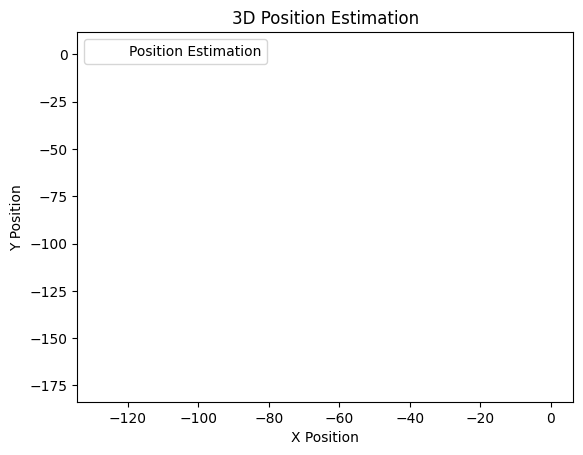

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(position_x, position_y, position_z, label='Position Estimation', c='b', marker='o')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Position Estimation')
ax.legend()

# Plot a sphere to represent the device
u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
x_sphere = np.cos(u)*np.sin(v)
y_sphere = np.sin(u)*np.sin(v)
z_sphere = np.cos(v)
# ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.1, antialiased=False, label='Device Sphere')

plt.show()

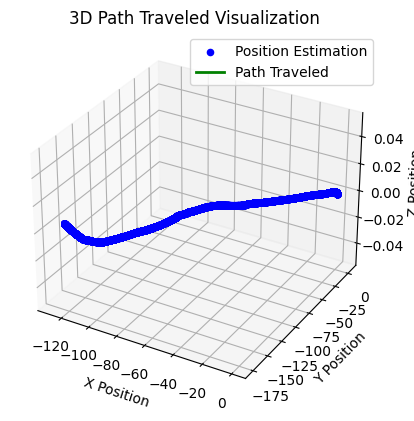

In [68]:
# Visualize on a 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the estimated positions
ax.scatter(position_x, position_y, position_z, label='Position Estimation', c='b', marker='o')

# Connect the estimated positions with lines to visualize the path
ax.plot(position_x, position_y, position_z, label='Path Traveled', linestyle='-', color='g', linewidth=2)

ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Path Traveled Visualization')
ax.legend()

# # Plot a sphere to represent the device
# u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
# x_sphere = np.cos(u)*np.sin(v)
# y_sphere = np.sin(u)*np.sin(v)
# z_sphere = np.cos(v)
# ax.plot_surface(x_sphere, y_sphere, z_sphere, color='r', alpha=0.1, antialiased=False, label='Device Sphere')

plt.show()

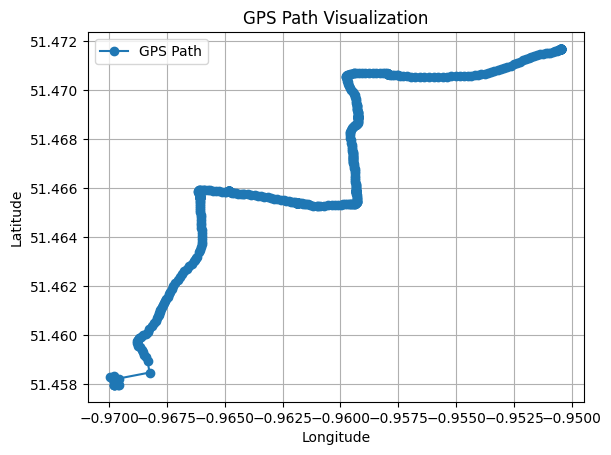

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the GPS dataset
df_gps = pd.read_csv('datasets_extracted/'+dataset+'/Location.csv')  # Replace "your_gps_dataset.csv" with the actual file path

# Extract GPS data
time_gps = df_gps['time'].values
longitude_gps = df_gps['longitude'].values
latitude_gps = df_gps['latitude'].values

# Plot the GPS path
plt.figure()
plt.plot(longitude_gps, latitude_gps, label='GPS Path', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('GPS Path Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
'''
# Extract GPS data
time_gps = df_gps['time'].values
longitude_gps = df_gps['longitude'].values
latitude_gps = df_gps['latitude'].values

# Plot the paths on the same graph
plt.figure(figsize=(10, 6))

# Plot IMU path
plt.plot(position_x, position_y, label='IMU Path', marker='o', linestyle='-', color='b')

# Plot GPS path
plt.plot(longitude_gps, latitude_gps, label='GPS Path', marker='o', linestyle='-', color='r')

plt.xlabel('Longitude / X Position')
plt.ylabel('Latitude / Y Position')
plt.title('Comparison of IMU and GPS Paths')
plt.legend()
plt.grid(True)
plt.show()
'''

"\n# Extract GPS data\ntime_gps = df_gps['time'].values\nlongitude_gps = df_gps['longitude'].values\nlatitude_gps = df_gps['latitude'].values\n\n# Plot the paths on the same graph\nplt.figure(figsize=(10, 6))\n\n# Plot IMU path\nplt.plot(position_x, position_y, label='IMU Path', marker='o', linestyle='-', color='b')\n\n# Plot GPS path\nplt.plot(longitude_gps, latitude_gps, label='GPS Path', marker='o', linestyle='-', color='r')\n\nplt.xlabel('Longitude / X Position')\nplt.ylabel('Latitude / Y Position')\nplt.title('Comparison of IMU and GPS Paths')\nplt.legend()\nplt.grid(True)\nplt.show()\n"

0        1701180133893555500
1        1701180133972900900
2        1701180133993994500
3        1701180134032518700
4        1701180134072263700
                ...         
17752    1701180724497268000
17753    1701180724522109700
17754    1701180724593689900
17755    1701180724596634600
17756    1701180724621476000
Name: time, Length: 17757, dtype: int64

### Using a Kalman Filter

In [72]:
from filterpy.kalman import KalmanFilter

#  Kalman filter estimated position coordinates
kf_position_x = [0]
kf_position_y = [0]
kf_position_z = [0]

# Initial orientation quaternion for Kalman filter
orientation_quaternion_imu = Quaternion()

# Initialize Kalman filter for position estimation
kf = KalmanFilter(dim_x=9, dim_z=3)
kf.F = np.eye(9)  # State transition matrix
kf.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0]])  # Measurement matrix
kf.P *= 1e3  # Initial covariance matrix
kf.R = np.diag([0.1, 0.1, 0.1])  # Measurement noise covariance
kf.Q = np.eye(9) * 1e-5  # Process noise covariance

# Sensor fusion and Kalman filter position estimation loop
for i in range(1, len(time)):
    dt_imu = (time[i] - time[i-1]) / 1e9

    angular_velocity_imu = gyroscope_data[i]
    delta_quaternion_imu = Quaternion(axis=angular_velocity_imu, radians=np.linalg.norm(angular_velocity_imu) * dt_imu)
    orientation_quaternion_imu = (orientation_quaternion_imu * delta_quaternion_imu).unit

    rotation_matrix_imu = orientation_quaternion_imu.rotation_matrix

    # Integrate accelerometer data for position estimation
    acceleration_imu = np.array(accelerometer_data[i])
    rotated_acceleration_imu = np.dot(rotation_matrix_imu, acceleration_imu)
    velocity_imu = np.array([rotated_acceleration_imu[0], rotated_acceleration_imu[1], 0]) * dt_imu
    position_change_imu = np.array(velocity_imu) * dt_imu
    new_position_imu = np.array([kf_position_x[i - 1], kf_position_y[i - 1], kf_position_z[i - 1]]) + position_change_imu

    # Kalman filter prediction step
    kf.predict()

    # Update Kalman filter with accelerometer measurement
    # kf.update(acceleration_imu)
    # Update Kalman filter with one-dimensional measurement
    kf.update(new_position_imu[:3]).reshape(-1, 1)

    # Update Kalman filter estimated position coordinates
    kf_position_x.append(kf.x[0])
    kf_position_y.append(kf.x[1])
    kf_position_z.append(kf.x[2])


AttributeError: 'NoneType' object has no attribute 'reshape'

### Complementary Filter

In [73]:
# Lists to store complementary filter estimated position coordinates
comp_position_x = [0]
comp_position_y = [0]
comp_position_z = [0]

# Initialize orientation quaternion
orientation_quaternion_comp = Quaternion()

# Complementary filter parameters
alpha = 0.5  # Weight for accelerometer data
beta = 0.7   # Weight for gyroscope data

# Sensor fusion and complementary filter position estimation loop
for i in range(1, len(time)):
    dt_imu = (time[i] - time[i-1]) / 1e9

    # Update orientation quaternion using gyroscope data
    angular_velocity_imu = gyroscope_data[i]
    delta_quaternion_imu = Quaternion(axis=angular_velocity_imu, radians=np.linalg.norm(angular_velocity_imu) * dt_imu)
    orientation_quaternion_imu = (orientation_quaternion_comp * delta_quaternion_imu).unit

    # Combine accelerometer and gyroscope data using complementary filter
    acceleration_imu = np.array(accelerometer_data[i])
    rotated_acceleration_imu = np.dot(orientation_quaternion_imu.rotation_matrix, acceleration_imu)
    
    comp_position_change_imu = alpha * np.array(rotated_acceleration_imu) * dt_imu
    comp_position_change_gyro = beta * np.array(gyroscope_data[i]) * dt_imu
    
    comp_position_change = comp_position_change_imu + comp_position_change_gyro
    
    new_position_comp = np.array([comp_position_x[i - 1], comp_position_y[i - 1], comp_position_z[i - 1]]) + comp_position_change

    # Update estimated position coordinates
    comp_position_x.append(new_position_comp[0])
    comp_position_y.append(new_position_comp[1])
    comp_position_z.append(new_position_comp[2])

In [74]:
num_samples = data_df.shape[0]
# Path tracing variables
position = np.zeros((num_samples, 3))  # Initial position is assumed to be at the origin
velocity = np.zeros((num_samples, 3))  # Initial velocity is assumed to be zero
orientation = np.zeros((num_samples, 3))  # Initial orientation is assumed to be zero
dt = 1.0  # Time step in seconds

# Kalman filter setup
kf = KalmanFilter(dim_x=9, dim_z=3)
kf.F = np.array([
    [1, dt, 0.5*dt**2, 0, 0, 0, 0, 0, 0],
    [0, 1, dt, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, dt, 0.5*dt**2, 0, 0, 0],
    [0, 0, 0, 0, 1, dt, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, dt, 0.5*dt**2],
    [0, 0, 0, 0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 0, 0, 0, 1]
])
kf.H = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0]
])
kf.P *= 1e2
kf.R *= 1e-1

# Main loop for path tracing
for t in range(1, num_samples):
    # Update velocity using accelerometer data
    velocity[t] = velocity[t - 1] + accelerometer_data[t] * dt

    # Update orientation using gyroscope data
    orientation[t] = orientation[t - 1] + gyroscope_data[t] * dt

    # Use Kalman filter to fuse accelerometer and magnetometer data
    accel = accelerometer_data[t]
    mag = magnetometer_data[t]
    z = np.concatenate((accel, mag))
    z = accel
    kf.predict()
    print(z)
    kf.update(z)

    # Extract position from the state estimate
    x_state = kf.x
    position[t] = x_state[0:3]

[-0.08205     3.35400009  9.17400074]


ValueError: could not broadcast input array from shape (3,1) into shape (3,)

In [75]:
from imufilter import MARGFilter


# Path tracing variables
position = np.zeros((num_samples, 3))  # Initial position is assumed to be at the origin
velocity = np.zeros((num_samples, 3))  # Initial velocity is assumed to be zero
dt = 1.0  # Time step in seconds

# IMU fusion setup
filter_params = {
    "accel_noise": 0.1,  # Accelerometer noise level
    "gyro_noise": 0.01,   # Gyroscope noise level
    "mag_noise": 0.1,    # Magnetometer noise level
    "accel_bias": 0.01,  # Accelerometer bias
    "gyro_bias": 0.001,   # Gyroscope bias
    "mag_bias": 0.01,    # Magnetometer bias
}

imu_filter = MARGFilter(**filter_params)

# Main loop for path tracing
for t in range(1, num_samples):
    # Update velocity using accelerometer data
    velocity[t] = velocity[t - 1] + accelerometer_data[t] * dt

    # Use IMU fusion to update orientation
    imu_filter.update(gyroscope_data[t], accelerometer_data[t], magnetometer_data[t])

    # Extract position from the IMU fusion filter
    position[t] = imu_filter.position


ModuleNotFoundError: No module named 'imufilter'

In [79]:
import plotly
import plotly.graph_objs as go

In [80]:
plotly.offline.init_notebook_mode()

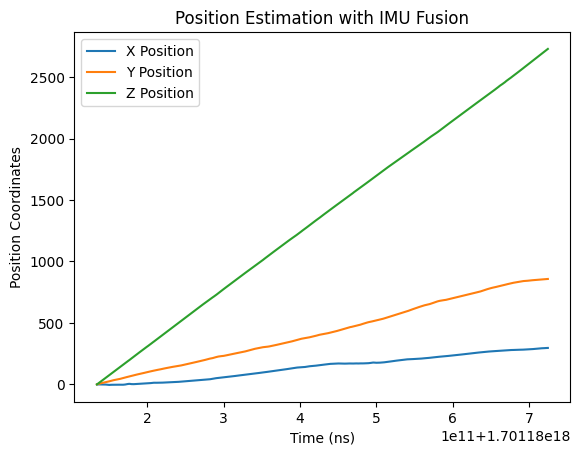

In [81]:
plt.figure()
plt.plot(time, comp_position_x, label='X Position')
plt.plot(time, comp_position_y, label='Y Position')
plt.plot(time, comp_position_z, label='Z Position')
plt.xlabel('Time (ns)')
plt.ylabel('Position Coordinates')
plt.title('Position Estimation with IMU Fusion')
plt.legend()
plt.show()

In [24]:
accelerometer_data

array([[-0.054     ,  0.184     ,  0.62199998],
       [-0.054     ,  0.184     ,  0.62199998],
       [-0.054     ,  0.184     ,  0.62199998],
       ...,
       [ 0.43799999, -0.118     ,  0.094     ],
       [-0.032     ,  0.31      ,  0.336     ],
       [-0.032     ,  0.31      ,  0.336     ]])

In [82]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R


num_samples = len(accelerometer_data)


# Path tracing variables
position = np.zeros((num_samples, 3))  # Initial position is assumed to be at the origin
velocity = np.zeros((num_samples, 3))  # Initial velocity is assumed to be zero
orientation = np.zeros((num_samples, 3))  # Initial orientation is assumed to be zero
dt = 1.0  # Time step in seconds

# Madgwick filter parameters
beta = 0.0414  # Filter gain

# Main loop for path tracing
for t in range(1, num_samples):
    # Update velocity using accelerometer data
    velocity[t] = velocity[t - 1] + accelerometer_data[t] * dt

    # Madgwick filter to update orientation using gyroscope and magnetometer data
    gyro_rad = np.radians(gyroscope_data[t])
    accel = accelerometer_data[t]
    mag = magnetometer_data[t]

    # Madgwick filter update
    r = R.from_quat(orientation[t - 1])
    orientation[t] = R.from_quat(r.apply(np.array([0.0, 0.0, 0.0]))).as_quat()  # Resetting to zero rotation
    orientation[t] = R.from_quat(orientation[t]).apply(gyro_rad)
    orientation[t] = R.from_quat(orientation[t]).apply(accel - np.array([0, 0, 9.81])) + np.array([0, 0, 9.81])
    orientation[t] = R.from_quat(orientation[t]).apply(mag)

    # Update position using velocity data and orientation
    rotation_matrix = R.from_quat(orientation[t]).as_matrix()
    velocity_rotated = np.dot(rotation_matrix, velocity[t])
    position[t] = position[t - 1] + velocity_rotated * dt

ValueError: Expected `quat` to have shape (4,) or (N x 4), got (3,).

In [83]:
# Configure the trace.
trace = go.Scatter3d(
    x=comp_position_x,  # <-- Put your data instead
    y=comp_position_y,  # <-- Put your data instead
    z=comp_position_z,  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 1,
        'opacity': 0.8,
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

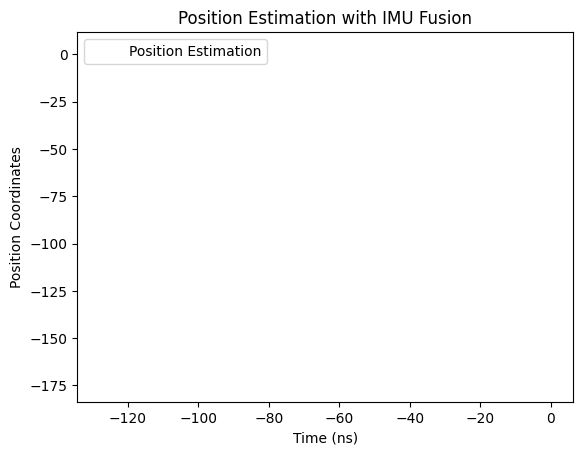

In [88]:
plt.figure()
plt.scatter(position_x, position_y, position_z, label='Position Estimation', c='b', marker='o')
plt.xlabel('Time (ns)')
plt.ylabel('Position Coordinates')
plt.title('Position Estimation with IMU Fusion')
plt.legend()
plt.show()

In [84]:
# Configure the trace.
trace = go.Scatter3d(
    x=position_x,  # <-- Put your data instead
    y=position_y,  # <-- Put your data instead
    z=position_z,  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 1,
        'opacity': 0.8,
    }
)

layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)